# Predicting Probability of Quitting and Providing Prevention Hints

## 1. Import Necessary Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
import os
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
import json

## 2. Load the Dataset and Check Duplicates

In [2]:
# Load the dataset
file_path = 'D:\Programmers Dev Course_Data Analyst Track\project3\HR_Dataset.csv'
df = pd.read_csv(file_path)

# Identify all duplicates, including their first occurrences
all_duplicates = df.duplicated(keep=False)

# Filter the DataFrame to show only duplicate rows
duplicate_rows_df = df[all_duplicates]

# Check if there are any duplicates
if not duplicate_rows_df.empty:
    # Sort the DataFrame by all columns to help in visually comparing the duplicate entries
    sorted_duplicate_rows_df = duplicate_rows_df.sort_values(by=list(df.columns))

    # Display the number of additional copies only
    # We use df.duplicated() without keep=False to count only the additional copies
    additional_copies_count = df.duplicated().sum()
    print(f'Number of additional duplicate copies (excluding the first occurrence): {additional_copies_count}')
    print('Duplicate Rows (including originals):')
    print(sorted_duplicate_rows_df)

    # Save to a CSV file if it doesn't exist
    csv_file_path = 'duplicate_rows.csv'
    if not os.path.exists(csv_file_path):
        sorted_duplicate_rows_df.to_csv(csv_file_path, index=False)
        print(f'All duplicate rows (including originals) have been saved to "{csv_file_path}".')
    else:
        print(f'The file "{csv_file_path}" already exists.')

    # Remove all duplicate rows, keeping only the first occurrence
    df = df.drop_duplicates()

    # Confirm the removal
    print(f'Number of rows after removing duplicates: {df.shape[0]}')
else:
    print('No duplicate rows found.')


Number of additional duplicate copies (excluding the first occurrence): 3008
Duplicate Rows (including originals):
       satisfaction_level  last_evaluation  number_project  \
30                   0.09             0.62               6   
12030                0.09             0.62               6   
14241                0.09             0.62               6   
71                   0.09             0.77               5   
12071                0.09             0.77               5   
...                   ...              ...             ...   
13089                1.00             0.88               6   
11375                1.00             0.93               5   
13586                1.00             0.93               5   
10691                1.00             0.93               5   
12902                1.00             0.93               5   

       average_montly_hours  time_spend_company  Work_accident  left  \
30                      294                   4              0     1

## 3. Correlations

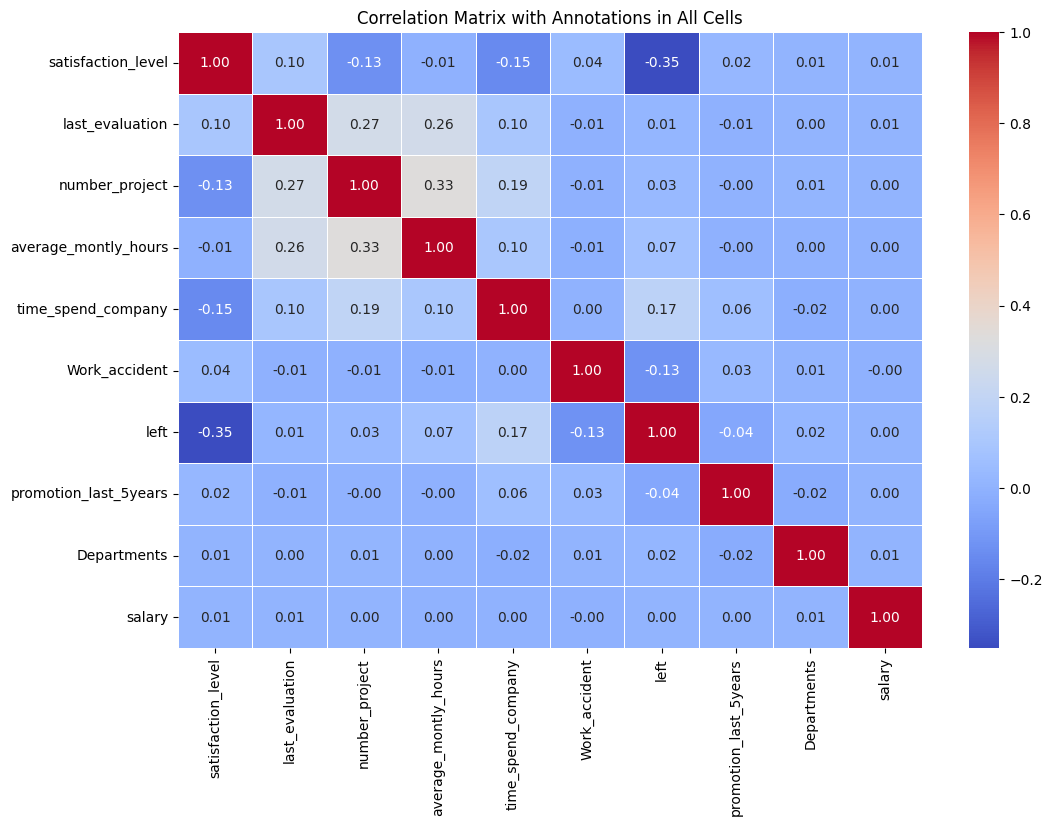

In [3]:
# Strip trailing spaces from column names
df.columns = df.columns.str.strip()

# Correct column names
department_col = 'Departments'
salary_col = 'salary'

# Encode categorical features into numerical values for correlation analysis
df_encoded = df.copy()
df_encoded[department_col] = df_encoded[department_col].astype('category').cat.codes
df_encoded[salary_col] = df_encoded[salary_col].astype('category').cat.codes

# Calculate the correlation matrix
corr_matrix = df_encoded.corr(numeric_only=True)

# Display the heatmap with annotations for all cells
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='white')
plt.title('Correlation Matrix with Annotations in All Cells')
plt.show()

## 4. Distribution and Relationships

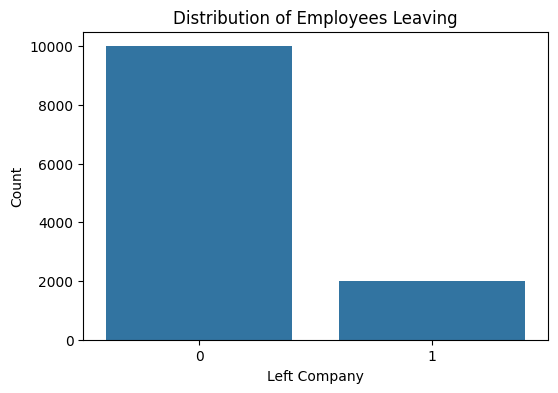

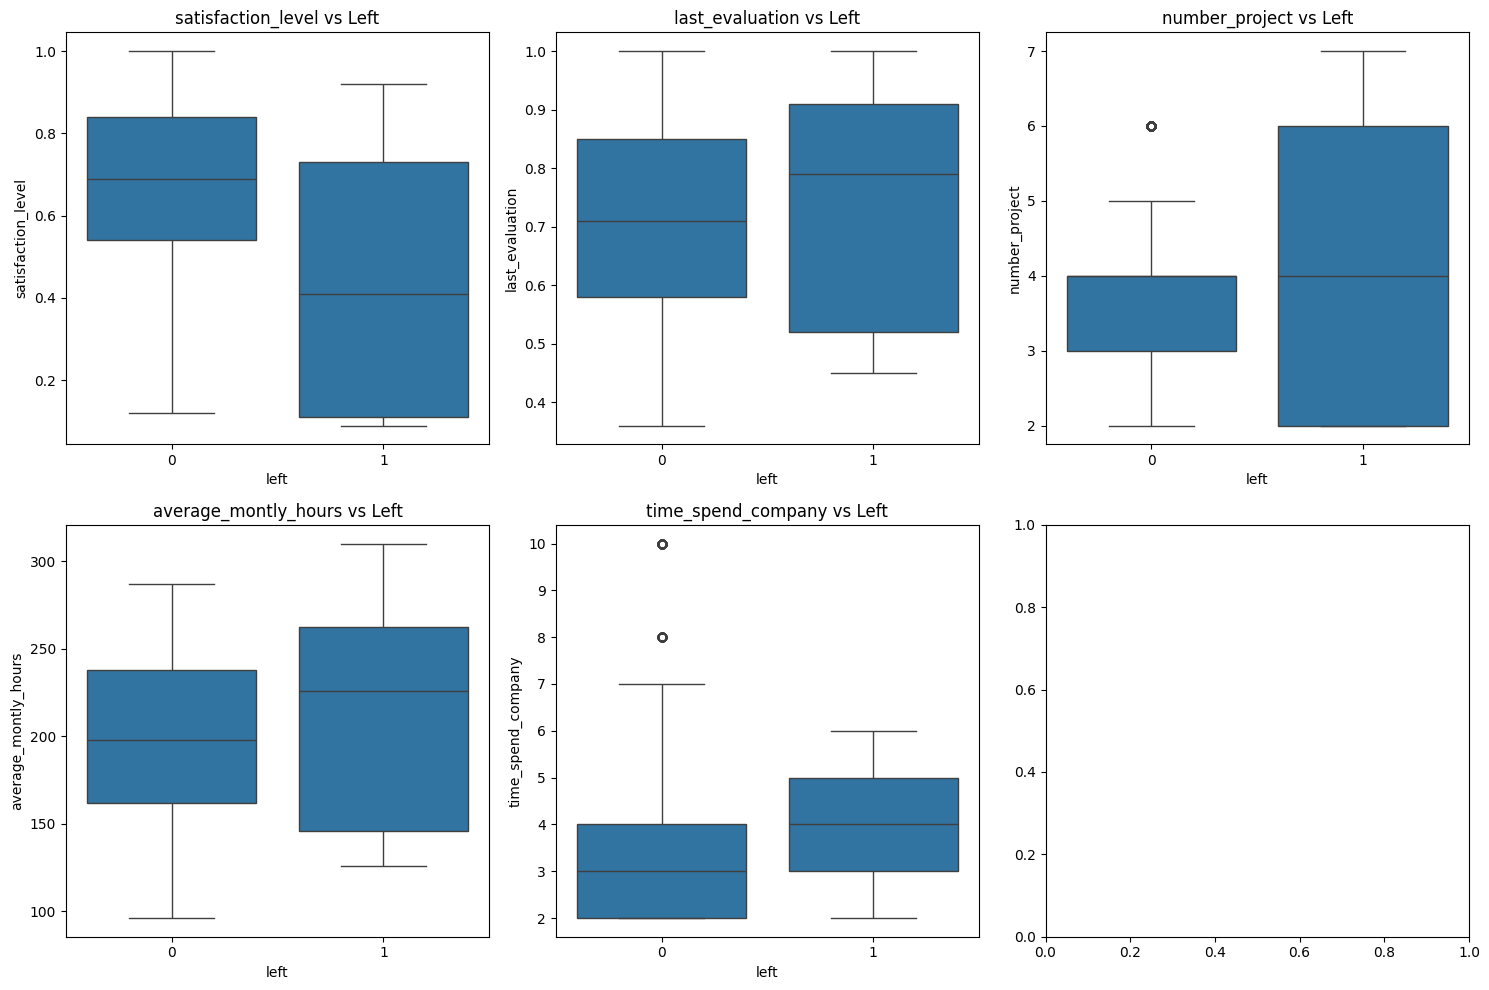

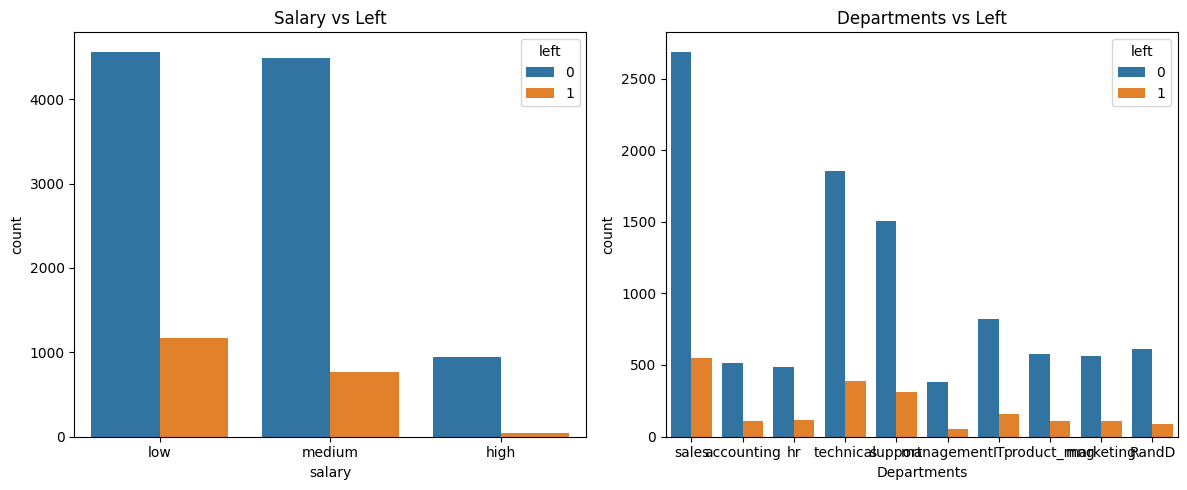

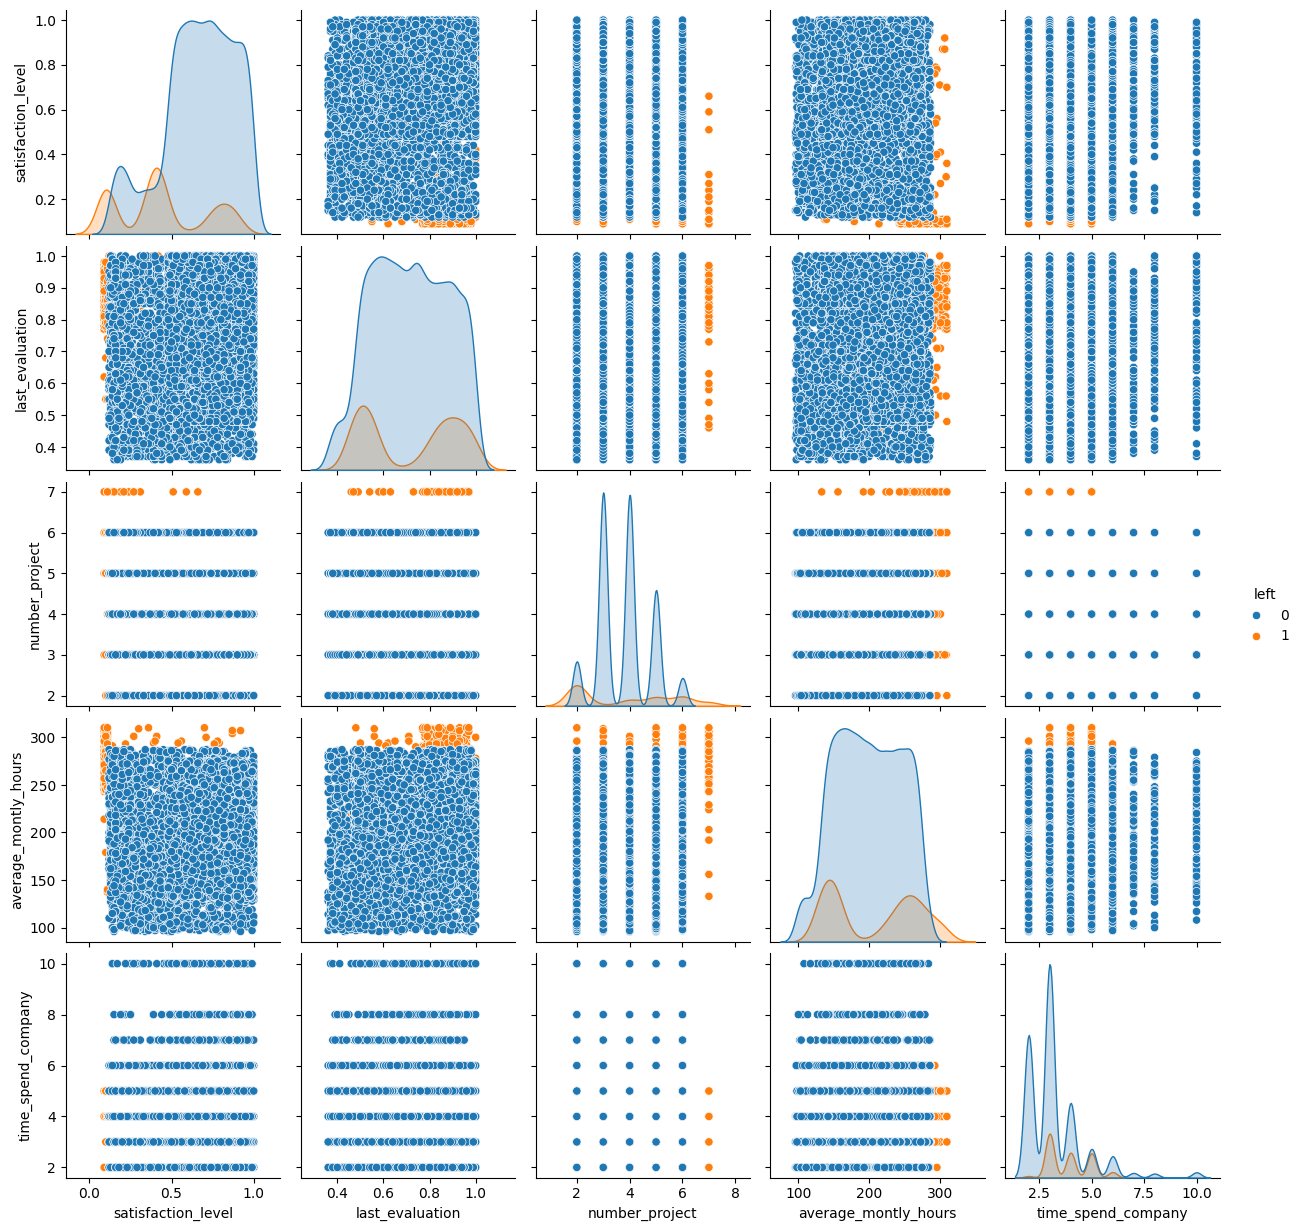

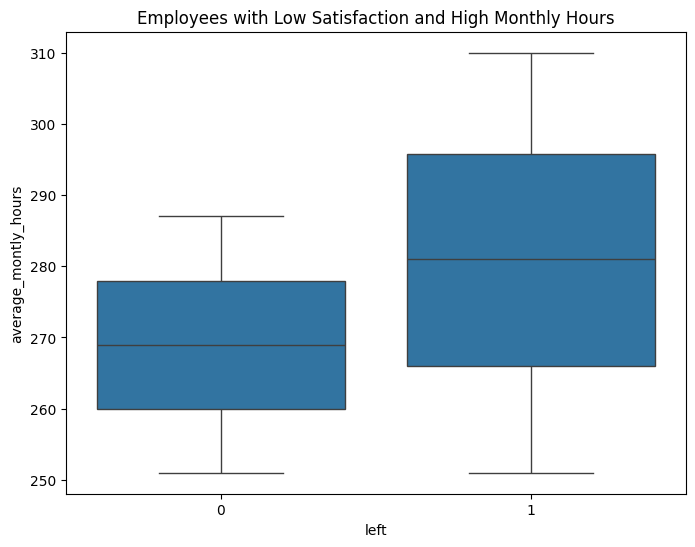

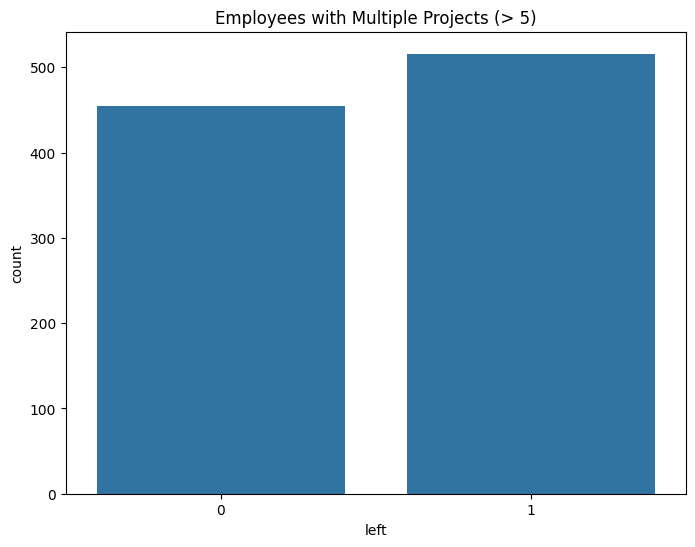

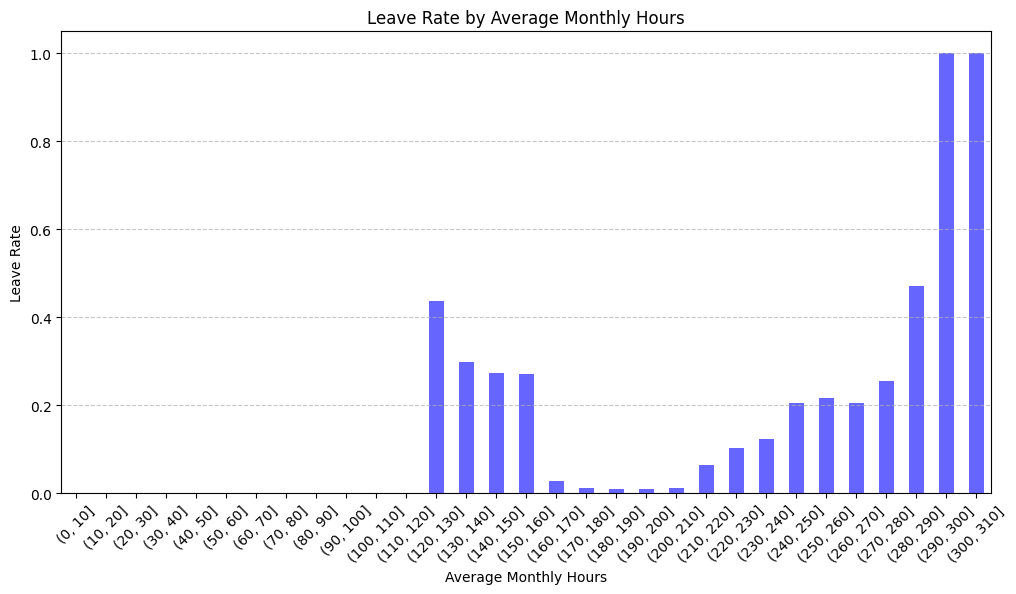

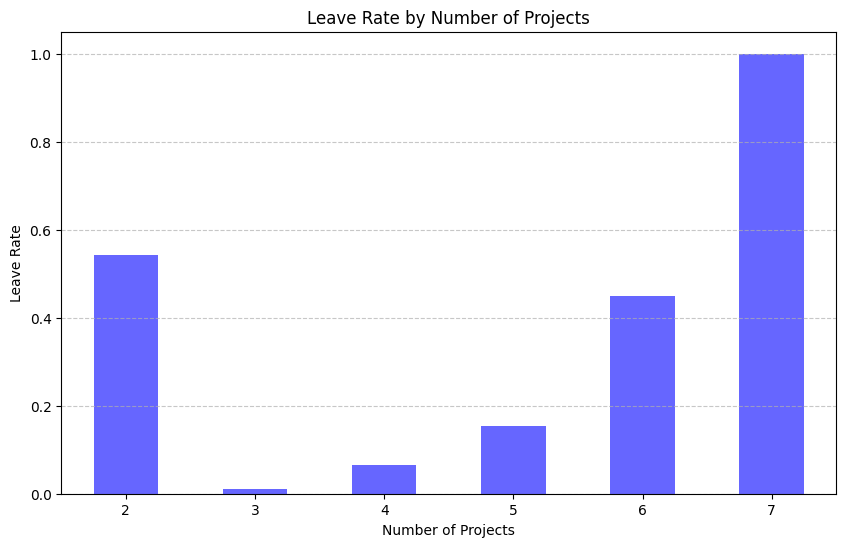

In [4]:
# Distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='left', data=df)
plt.title('Distribution of Employees Leaving')
plt.xlabel('Left Company')
plt.ylabel('Count')
plt.show()

# Visualize relationships between features and target
features = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company']
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, feature in enumerate(features):
    sns.boxplot(x='left', y=feature, data=df, ax=axs[i])
    axs[i].set_title(f'{feature} vs Left')
plt.tight_layout()
plt.show()

# Visualize categorical features
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x='salary', hue='left', data=df, ax=axs[0])
sns.countplot(x='Departments', hue='left', data=df, ax=axs[1])
axs[0].set_title('Salary vs Left')
axs[1].set_title('Departments vs Left')
plt.tight_layout()
plt.show()

# Pair plot of selected features
selected_features = ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'left']
sns.pairplot(df[selected_features], hue='left')
plt.show()

# Explore interesting insights
# Employees with the lowest satisfaction levels (<= 0.3) and high monthly hours (> 250) are likely to leave
high_hours_low_satisfaction = df[(df['satisfaction_level'] <= 0.3) & (df['average_montly_hours'] > 250)]
plt.figure(figsize=(8, 6))
sns.boxplot(x='left', y='average_montly_hours', data=high_hours_low_satisfaction)
plt.title('Employees with Low Satisfaction and High Monthly Hours')
plt.show()

# Employees with multiple projects (>5) are likely to leave
multiple_projects = df[(df['number_project'] > 5)]
plt.figure(figsize=(8, 6))
sns.countplot(x='left', data=multiple_projects)
plt.title('Employees with Multiple Projects (> 5)')
plt.show()

# Plot the leave rate by average monthly hours
def plot_left_rate_by_hours(df, bin_width=10):
    bins = range(0, df['average_montly_hours'].max() + bin_width, bin_width)
    df['hours_bin'] = pd.cut(df['average_montly_hours'], bins=bins)
    grouped = df.groupby('hours_bin')['left'].mean()
    count = df.groupby('hours_bin')['left'].count()

    plt.figure(figsize=(12, 6))
    grouped.plot(kind='bar', color='blue', alpha=0.6)
    plt.xlabel('Average Monthly Hours')
    plt.ylabel('Leave Rate')
    plt.title('Leave Rate by Average Monthly Hours')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot leave rate by average monthly hours
plot_left_rate_by_hours(df)

# Plot leave rate by number of projects
def plot_left_rate_by_projects(df):
    grouped = df.groupby('number_project')['left'].mean()
    count = df.groupby('number_project')['left'].count()

    plt.figure(figsize=(10, 6))
    grouped.plot(kind='bar', color='blue', alpha=0.6)
    plt.xlabel('Number of Projects')
    plt.ylabel('Leave Rate')
    plt.title('Leave Rate by Number of Projects')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot leave rate by number of projects
plot_left_rate_by_projects(df)

## 5. Prepare the Data

In [5]:
# Define the feature columns and the target column for classification
X_class = df.drop(columns=['left'])
y_class = df['left']

# Define the feature columns and the target column for regression
X_reg = df.drop(columns=['satisfaction_level', 'left'])
y_reg = df['satisfaction_level']

# Identify categorical and numerical columns
categorical_cols = X_class.select_dtypes(include=['object']).columns
numerical_cols = X_class.select_dtypes(include=['int64', 'float64']).columns

# Separate ordinal and nominal columns
ordinal_cols = ['salary']
nominal_cols = [col for col in categorical_cols if col not in ordinal_cols]

# Define the ordinal encoder for the 'salary' column
salary_categories = ['low', 'medium', 'high']
ordinal_encoder = OrdinalEncoder(categories=[salary_categories])

# Preprocessing pipeline for classification
preprocessor_class = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('ord', ordinal_encoder, ordinal_cols),
        ('nom', OneHotEncoder(drop='first', handle_unknown='ignore'), nominal_cols)
    ]
)

# Preprocessing pipeline for regression
preprocessor_reg = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_reg.select_dtypes(include=['int64', 'float64']).columns),
        ('ord', ordinal_encoder, ordinal_cols),
        ('nom', OneHotEncoder(drop='first', handle_unknown='ignore'), nominal_cols)
    ]
)

# Split data into training and test sets for classification
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X_class, y_class, test_size=0.3, random_state=42)

# Split data into training and test sets for regression
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

## 6. Resampling Techniques for Classification

In [6]:
# Function to resample data using different techniques
def resample_data(X, y, sampler):
    X_resampled, y_resampled = sampler.fit_resample(X, y)
    print(f"Resampled dataset shape: {Counter(y_resampled)}")
    return X_resampled, y_resampled

# Apply resampling techniques
samplers = {
    'Random OverSampler': RandomOverSampler(random_state=42),
    'SMOTE': SMOTE(random_state=42),
    'Borderline SMOTE': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42)
}

X_class_train_transformed = preprocessor_class.fit_transform(X_class_train)

resampled_datasets = {}
for name, sampler in samplers.items():
    print(f'Applying {name}...')
    X_resampled, y_resampled = resample_data(X_class_train_transformed, y_class_train, sampler)
    resampled_datasets[name] = (X_resampled, y_resampled)
    print('-' * 40)

# Also include the original dataset
resampled_datasets['Original'] = (X_class_train_transformed, y_class_train)

Applying Random OverSampler...
Resampled dataset shape: Counter({0: 7005, 1: 7005})
----------------------------------------
Applying SMOTE...
Resampled dataset shape: Counter({0: 7005, 1: 7005})
----------------------------------------
Applying Borderline SMOTE...
Resampled dataset shape: Counter({0: 7005, 1: 7005})
----------------------------------------
Applying ADASYN...
Resampled dataset shape: Counter({0: 7005, 1: 7003})
----------------------------------------


## 7. Hyperparameter Tuning and Evaluation Functions

In [7]:
# Define dictionaries for classification and regression models with respective hyperparameters
classification_models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

regression_models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest Regressor': RandomForestRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(random_state=42),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor()
}

# Hyperparameter grids
param_grids_classification = {
    'Logistic Regression': {'model__C': [0.01, 0.1, 1, 10]},
    'Random Forest': {'model__n_estimators': [50, 100, 150], 'model__max_depth': [5, 10, 15]},
    'XGBoost': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, 7]},
    'Gradient Boosting': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5]},
    'K-Nearest Neighbors': {'model__n_neighbors': [3, 5, 7]}
}

param_grids_regression = {
    'Linear Regression': {},
    'Decision Tree': {'model__max_depth': [3, 5, 7]},
    'Random Forest Regressor': {'model__n_estimators': [50, 100, 150], 'model__max_depth': [5, 10, 15]},
    'XGBRegressor': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, 7]},
    'Gradient Boosting Regressor': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5]},
    'K-Nearest Neighbors Regressor': {'model__n_neighbors': [3, 5, 7]}
}

# Function to find best hyperparameters for classification models
def find_best_hyperparameters_classification(X_train, y_train, X_test, y_test):
    alpha = 0.9
    best_performance = 0
    best_model_info = {}
    model_performance = {}

    for sampler_name, (X_resampled, y_resampled) in resampled_datasets.items():
        print(f'### Evaluating models for {sampler_name} dataset ###')
        for model_name, model in classification_models.items():
            start_time = time.time()
            pipeline = Pipeline([('model', model)])
            grid = GridSearchCV(pipeline, param_grids_classification[model_name], cv=3, scoring='roc_auc')
            grid.fit(X_resampled, y_resampled)
            end_time = time.time()

            training_time = end_time - start_time
            y_pred_proba = grid.predict_proba(X_test)[:, 1]
            auc = roc_auc_score(y_test, y_pred_proba)
            performance = alpha * auc + (1 - alpha) * (1 / training_time)

            print(f'{model_name}: ROC AUC Score = {auc:.3f}, Training Time: {training_time:.3f} seconds, Best Params: {grid.best_params_}')

            model_performance[model_name] = {'performance': performance, 'auc': auc, 'training_time': training_time, 'sampler': sampler_name, 'params': grid.best_params_}

            # if performance > best_performance:
            if model_name == 'XGBoost' and performance > best_performance:
                best_performance = performance
                best_model_info = {'model': model_name, 'auc': auc, 'sampler': sampler_name}

        print('-' * 50)

    print(f'Best Classification Model overall considering performance and training time: {best_model_info["model"]} with {best_model_info["sampler"]} (ROC AUC Score = {best_model_info["auc"]:.3f})')

    return best_model_info

# Function to find best hyperparameters for regression models with weighted performance
def find_best_hyperparameters_regression(X_train, y_train, X_test, y_test):
    alpha = 0.9  # Weight for the performance metric
    best_performance = -float('inf')
    best_model_info = {}
    model_performance = {}
    for model_name, model in regression_models.items():
        start_time = time.time()
        pipeline = Pipeline([('model', model)])
        grid = GridSearchCV(pipeline, param_grids_regression[model_name], cv=3, scoring='r2')
        grid.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        y_pred = grid.predict(X_test)
        r2 = r2_score(y_test, y_pred)
        performance = alpha * r2 + (1 - alpha) * (1 / training_time)
        print(f'{model_name}: R2 = {r2:.3f}, Training Time: {training_time:.3f} seconds, Best Params: {grid.best_params_}')
        model_performance[model_name] = {'performance': performance, 'r2': r2, 'training_time': training_time, 'params': grid.best_params_}
        # if performance > best_performance:
        if model_name == 'XGBRegressor' and performance > best_performance:
            best_performance = performance
            best_model_info = {'model': model_name, 'r2': r2, 'params': grid.best_params_, 'model_object': grid.best_estimator_}
    print(f'Best Regression Model overall considering performance and training time: {best_model_info["model"]} with R2 Score = {best_model_info["r2"]:.3f}')
    return best_model_info


## 8. Cross-Validation Functions for Overfitting Check

In [8]:
# Cross-validation function for classification
def cross_val_classification(model, X, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X, y, cv=skf, scoring='roc_auc')
    print(f'Cross-Validation ROC AUC Scores: {auc_scores}')
    print(f'Mean ROC AUC Score: {auc_scores.mean():.3f}')
    print(f'Standard Deviation: {auc_scores.std():.3f}')
    return auc_scores

# Cross-validation function for regression
def cross_val_regression(model, X, y):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    print(f'Cross-Validation R2 Scores: {r2_scores}')
    print(f'Mean R2 Score: {r2_scores.mean():.3f}')
    print(f'Standard Deviation: {r2_scores.std():.3f}')
    return r2_scores


## 9. Find Best Models and Perform Feature Importance Analysis

### Evaluating models for Random OverSampler dataset ###
Logistic Regression: ROC AUC Score = 0.845, Training Time: 0.264 seconds, Best Params: {'model__C': 0.1}
Random Forest: ROC AUC Score = 0.982, Training Time: 12.041 seconds, Best Params: {'model__max_depth': 15, 'model__n_estimators': 150}
XGBoost: ROC AUC Score = 0.980, Training Time: 1.499 seconds, Best Params: {'model__max_depth': 7, 'model__n_estimators': 100}
Gradient Boosting: ROC AUC Score = 0.981, Training Time: 8.713 seconds, Best Params: {'model__max_depth': 5, 'model__n_estimators': 100}
K-Nearest Neighbors: ROC AUC Score = 0.948, Training Time: 0.429 seconds, Best Params: {'model__n_neighbors': 7}
--------------------------------------------------
### Evaluating models for SMOTE dataset ###
Logistic Regression: ROC AUC Score = 0.844, Training Time: 0.213 seconds, Best Params: {'model__C': 0.1}
Random Forest: ROC AUC Score = 0.979, Training Time: 15.980 seconds, Best Params: {'model__max_depth': 15, 'model__n_estimator

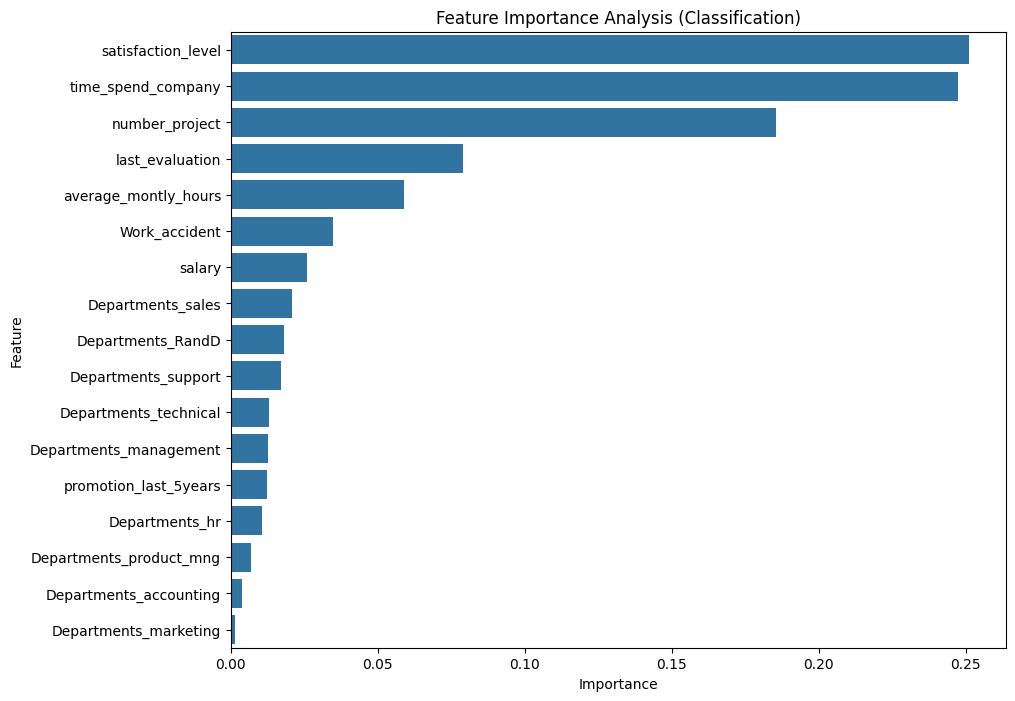

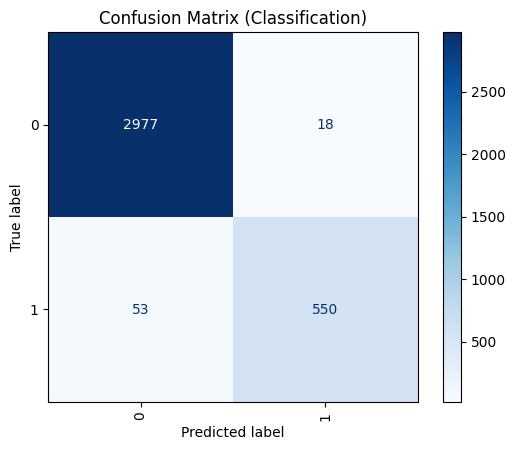

Accuracy: 0.980
Precision: 0.968
Recall: 0.912
F1 Score: 0.939
ROC AUC Score: 0.979


In [9]:
# Find best classification model
best_class_model_info = find_best_hyperparameters_classification(
    preprocessor_class.transform(X_class_train),
    y_class_train,
    preprocessor_class.transform(X_class_test),
    y_class_test
)

# Extract feature names from the preprocessing pipeline for classification
feature_names_num = numerical_cols.tolist()
feature_names_ord = ordinal_cols
feature_names_nom = preprocessor_class.named_transformers_['nom'].get_feature_names_out(nominal_cols)

all_feature_names = np.concatenate([feature_names_num, feature_names_ord, feature_names_nom])

# Ensure resampled data remains a DataFrame
X_resampled, y_resampled = resampled_datasets[best_class_model_info['sampler']]
X_resampled_df = pd.DataFrame(X_resampled, columns=all_feature_names)

# Fit the best model
best_class_model = best_class_model_info['model']
if isinstance(best_class_model, str):
    best_class_model = classification_models[best_class_model]
best_class_model = best_class_model.fit(X_resampled_df, y_resampled)

# Perform cross-validation for classification model
print('\nCross-Validation Results (Classification Model)')
cross_val_classification(best_class_model, X_resampled_df, y_resampled)

# Check if the model has 'feature_importances_'
if hasattr(best_class_model, 'feature_importances_'):
    # Extract feature importance
    feature_importances = best_class_model.feature_importances_

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance Analysis (Classification)')
    plt.show()

    importance_df.head(10)
else:
    print('No feature importances available for this model.')

# Confusion matrix
y_pred_class = best_class_model.predict(preprocessor_class.transform(X_class_test))
cm = confusion_matrix(y_class_test, y_pred_class)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_class_model.classes_)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix (Classification)')
plt.show()

# Evaluation metrics
accuracy = accuracy_score(y_class_test, y_pred_class)
precision = precision_score(y_class_test, y_pred_class)
recall = recall_score(y_class_test, y_pred_class)
f1 = f1_score(y_class_test, y_pred_class)
roc_auc = roc_auc_score(y_class_test, best_class_model.predict_proba(preprocessor_class.transform(X_class_test))[:, 1])

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1 Score: {f1:.3f}')
print(f'ROC AUC Score: {roc_auc:.3f}')

Linear Regression: R2 = 0.049, Training Time: 0.019 seconds, Best Params: {}
Decision Tree: R2 = 0.347, Training Time: 0.089 seconds, Best Params: {'model__max_depth': 5}
Random Forest Regressor: R2 = 0.381, Training Time: 21.543 seconds, Best Params: {'model__max_depth': 10, 'model__n_estimators': 150}
XGBRegressor: R2 = 0.361, Training Time: 1.185 seconds, Best Params: {'model__max_depth': 3, 'model__n_estimators': 50}
Gradient Boosting Regressor: R2 = 0.370, Training Time: 4.182 seconds, Best Params: {'model__max_depth': 5, 'model__n_estimators': 50}
K-Nearest Neighbors Regressor: R2 = 0.274, Training Time: 0.199 seconds, Best Params: {'model__n_neighbors': 7}
Best Regression Model overall considering performance and training time: XGBRegressor with R2 Score = 0.361

Cross-Validation Results (Regression Model)
Cross-Validation R2 Scores: [0.35372789 0.32279152 0.34256078 0.35976268 0.40051344]
Mean R2 Score: 0.356
Standard Deviation: 0.026


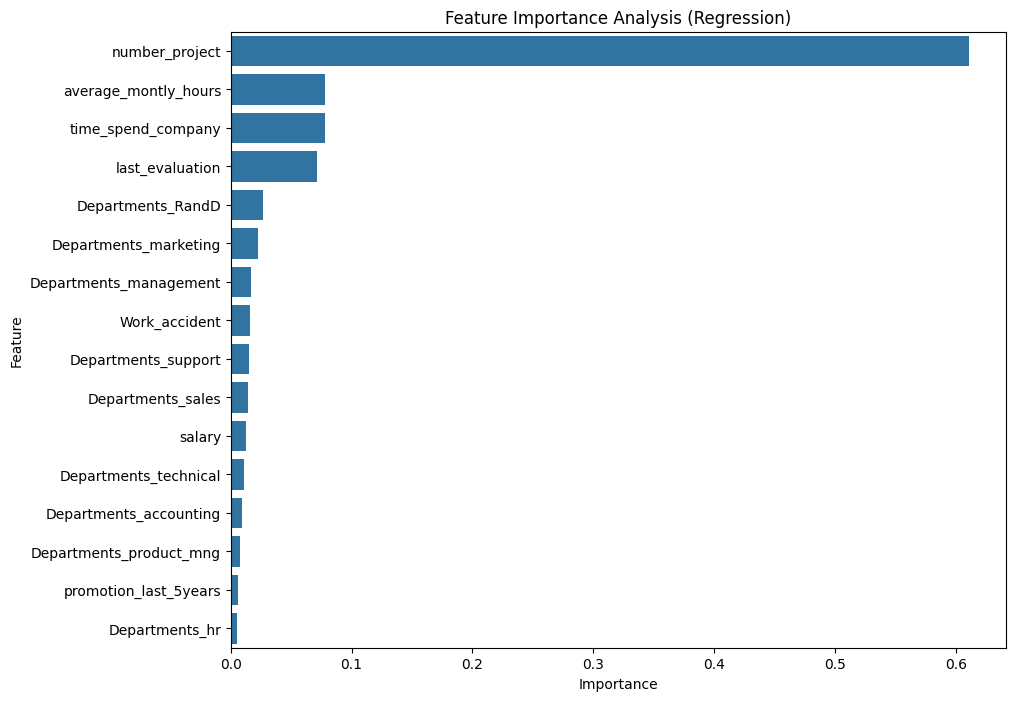

In [10]:
# Find best regression model
best_reg_model_info = find_best_hyperparameters_regression(
    preprocessor_reg.fit_transform(X_reg_train),
    y_reg_train,
    preprocessor_reg.transform(X_reg_test),
    y_reg_test
)

# Extract feature names from the preprocessing pipeline for regression
feature_names_num_reg = X_reg.select_dtypes(include=['int64', 'float64']).columns.tolist()
feature_names_ord = ordinal_cols
feature_names_nom = preprocessor_reg.named_transformers_['nom'].get_feature_names_out(nominal_cols)

all_feature_names_reg = np.concatenate([feature_names_num_reg, feature_names_ord, feature_names_nom])

# Fit the best model
best_reg_model = best_reg_model_info['model_object']
best_reg_model = best_reg_model.fit(preprocessor_reg.fit_transform(X_reg_train), y_reg_train)

# Perform cross-validation for regression model
print('\nCross-Validation Results (Regression Model)')
cross_val_regression(best_reg_model, preprocessor_reg.transform(X_reg_train), y_reg_train)

# Check if the model has 'feature_importances_'
if hasattr(best_reg_model.named_steps['model'], 'feature_importances_'):
    # Extract feature importance
    feature_importances_reg = best_reg_model.named_steps['model'].feature_importances_

    # Create a DataFrame for visualization
    importance_df_reg = pd.DataFrame({'Feature': all_feature_names_reg, 'Importance': feature_importances_reg})
    importance_df_reg = importance_df_reg.sort_values(by='Importance', ascending=False)

    # Plot the feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df_reg)
    plt.title('Feature Importance Analysis (Regression)')
    plt.show()

    importance_df_reg.head(10)
else:
    print('No feature importances available for this model.')


## 10. Check Multicollinearity with VIF (Variance Inflation Factor)

In [11]:
# Function to calculate VIF
def calculate_vif(X):
    X = sm.add_constant(X)
    vif_df = pd.DataFrame()
    vif_df['Feature'] = X.columns
    vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_df[vif_df['Feature'] != 'const']

# VIF for classification model
X_class_vif = preprocessor_class.fit_transform(X_class_train)
X_class_vif_df = pd.DataFrame(X_class_vif, columns=all_feature_names)
vif_class = calculate_vif(X_class_vif_df)

# VIF for regression model
X_reg_vif = preprocessor_reg.fit_transform(X_reg_train)
X_reg_vif_df = pd.DataFrame(X_reg_vif, columns=all_feature_names_reg)
vif_reg = calculate_vif(X_reg_vif_df)

# Display VIF results
print('Variance Inflation Factor (VIF) - Classification Model:')
print(vif_class)
print('\nVariance Inflation Factor (VIF) - Regression Model:')
print(vif_reg)

Variance Inflation Factor (VIF) - Classification Model:
                    Feature       VIF
1        satisfaction_level  1.068027
2           last_evaluation  1.146947
3            number_project  1.221450
4      average_montly_hours  1.160250
5        time_spend_company  1.084388
6             Work_accident  1.003996
7     promotion_last_5years  1.029254
8                    salary  1.025393
9         Departments_RandD  1.615933
10   Departments_accounting  1.548496
11           Departments_hr  1.534355
12   Departments_management  1.471403
13    Departments_marketing  1.624864
14  Departments_product_mng  1.608088
15        Departments_sales  3.147648
16      Departments_support  2.400642
17    Departments_technical  2.664458

Variance Inflation Factor (VIF) - Regression Model:
                    Feature       VIF
1           last_evaluation  1.122778
2            number_project  1.194973
3      average_montly_hours  1.159926
4        time_spend_company  1.060021
5             Wor